In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

In [2]:
# Set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
def sampleFromLieGroup(generator, coef_dist_sampler=None, n_sample=1):
    # returns: g: (b, k, k), g_inv: (b, k, k)
    if coef_dist_sampler is not None:
        z = coef_dist_sampler(n_sample)  # (b, c)
        g = torch.matrix_exp(torch.einsum('bc,cjk->bjk', z, generator))
        g_inv = torch.matrix_exp(torch.einsum('bc,cjk->bjk', -z, generator))
    else:  # this is for SymmetryGAN (individual group elements)
        generator = torch.cat([generator, torch.eye(generator.shape[-1]).unsqueeze(0)])  # add identity
        c = generator.shape[0]  # number of elements
        g = generator[torch.randint(0, c, (n_sample,)), :, :]
        g_inv = torch.linalg.inv(g)
    return g, g_inv

In [4]:
class GaussianSampler:
    def __init__(self, dim, mu, sigma):
        self.dim = dim
        self.mu = mu
        self.sigma = sigma
        
    def __call__(self, n_sample):
        return (torch.randn(n_sample, self.dim) @ self.sigma + self.mu).view(n_sample, -1)

In [5]:
class AugPredictionModel(nn.Module):
    def __init__(self, n_dim, n_tin, n_tout, generator, coef_dist_sampler, hidden_dim=32, n_copy=4, aug_eval=True):
        super().__init__()
        self.n_dim = n_dim
        self.n_tin = n_tin
        self.n_tout = n_tout
        self.generator = generator
        if len(self.generator.shape) == 2:
            self.generator.unsqueeze_(0)
        self.coef_dist_sampler = coef_dist_sampler
        self.n_copy = n_copy
        self.hidden_dim = hidden_dim
        self.aug_eval = aug_eval
        self.model = nn.Sequential(
            nn.Linear(n_dim * n_tin, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_dim * n_tout),
        )
        
    def forward(self, x):
        # x: (b, tin, k)
        b = x.shape[0]
        x = x.view(b, self.n_tin, -1)
        if self.training:
            g, g_inv = sampleFromLieGroup(self.generator, self.coef_dist_sampler, b)
            g, g_inv = g.to(x.device), g_inv.to(x.device)
            gx = torch.einsum('bjk,btk->btj', g, x).reshape(b, -1)
            gy = self.model(gx).view(b, self.n_tout, -1)
            y = torch.einsum('bjk, btk->btj', g_inv, gy)
        elif self.aug_eval:
            x_copies = []
            g_inv_list = []
            for _ in range(self.n_copy):
                g, g_inv = sampleFromLieGroup(self.generator, self.coef_dist_sampler, b)
                g, g_inv = g.to(x.device), g_inv.to(x.device)
                gx = torch.einsum('bjk,btk->btj', g, x).reshape(b, -1)
                x_copies.append(gx)
                g_inv_list.append(g_inv)
            x_aug = torch.cat(x_copies, dim=0)  # (N*b, tin*k)
            g_inv = torch.cat(g_inv_list, dim=0)  # (N*b, k, k)
            y_aug = self.model(x_aug).view(self.n_copy * b, self.n_tout, -1)  # (N*b, tout, k)
            y_aug = torch.einsum('bjk, btk->btj', g_inv, y_aug)
            y = torch.mean(torch.stack(torch.split(y_aug, b)), dim=0)
        else:
            y = self.model(x.view(b, -1))
        return y.reshape(b, -1)

In [6]:
# 0: LieGAN 2*2 search space
G0 = torch.load('./saved_model/results/generator-2body-liegan.pt')
mask0 = torch.block_diag(torch.ones(2, 2), torch.ones(2, 2), torch.ones(2, 2), torch.ones(2, 2))
G0 = (G0['Li'][0, :, :].to('cpu') * mask0).numpy()
# 1: LieGAN 4*4 search space
G1 = torch.load('./saved_model/results/generator-2body-liegan-es.pt')
mask1 = torch.block_diag(torch.ones(4, 4), torch.ones(4, 4))
p = torch.eye(8)
p[4:6,2:4] = p[2:4,4:6] = torch.eye(2)
p[2:4,2:4] = p[4:6,4:6] = 0
mask = p @ mask1 @ p
G1 = (G1['Li'][0, :, :].to('cpu')).numpy()
# 2: Modified Augerino
G2 = torch.load('./saved_model/results/augerino-2body.pt')
G2 = (G2['aug.Li'][0, :, :].to('cpu') * mask0).numpy()
# 3: Ground truth
GT = np.zeros_like(G0)
GT[1,0]=GT[3,2]=GT[5,4]=GT[7,6]=-1
GT[0,1]=GT[2,3]=GT[4,5]=GT[6,7]=1
# 4: SGAN
GS = torch.load('./saved_model/results/sgan-2body.pt')
GS = (GS['Li'].to('cpu') * mask0).numpy()

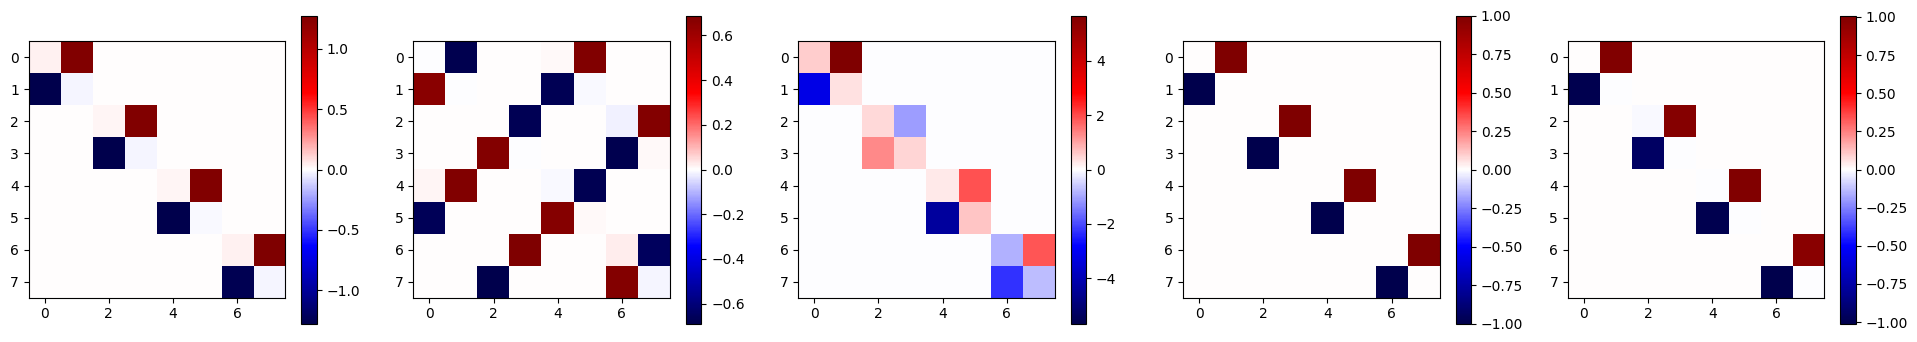

In [7]:
plt.figure(figsize=(24,4))
plt.subplot(1, 5, 1)
plt.imshow(G0, cmap='seismic', vmin=-np.max(np.abs(G0)), vmax=np.max(np.abs(G0)))
plt.colorbar()
plt.subplot(1, 5, 2)
plt.imshow(G1, cmap='seismic', vmin=-np.max(np.abs(G1)), vmax=np.max(np.abs(G1)))
plt.colorbar()
plt.subplot(1, 5, 3)
plt.imshow(G2, cmap='seismic', vmin=-np.max(np.abs(G2)), vmax=np.max(np.abs(G2)))
plt.colorbar()
plt.subplot(1, 5, 4)
plt.imshow(GT, cmap='seismic', vmin=-np.max(np.abs(GT)), vmax=np.max(np.abs(GT)))
plt.colorbar()
plt.subplot(1, 5, 5)
plt.imshow(GS, cmap='seismic', vmin=-np.max(np.abs(GS)), vmax=np.max(np.abs(GS)))
plt.colorbar()

In [8]:
input_timesteps = 5
output_timesteps = 5
n_dim = 8
BS = 512
lr = 1e-4
NUM_EPOCHS = 2000
TEST_PERIOD = 10
device = 'cuda'
criterion = nn.MSELoss(reduction='mean')

In [9]:
from dataset import NBodyDataset
trainset = NBodyDataset(
    input_timesteps=input_timesteps,
    output_timesteps=output_timesteps,
    trj_timesteps=20,
    save_path=f'./data/hnn/2body-orbits-dataset.pkl',
    flatten=True,
)
testset = NBodyDataset(
    input_timesteps=input_timesteps,
    output_timesteps=output_timesteps,
    trj_timesteps=20,
    save_path=f'./data/hnn/2body-orbits-dataset.pkl',
    flatten=True,
    mode='test',
#     with_random_transform=True
)

In [10]:
trainloader = DataLoader(trainset,batch_size=BS,shuffle=True)
testloader = DataLoader(testset,batch_size=BS,shuffle=True)

In [11]:
gen_list = [G0, G1, G2, GT, GS]
gen_list = [torch.FloatTensor(G) for G in gen_list]
mu = torch.FloatTensor([0,])
sigma = torch.FloatTensor([3,])
sampler_list = [GaussianSampler(1, mu, sigma)] * 4 + [None]
model_list = [AugPredictionModel(n_dim, input_timesteps, output_timesteps, G, sampler, aug_eval=False).to(device)
              for G, sampler in zip(gen_list, sampler_list)]

In [25]:
train_losses, test_losses = [], []
for model in model_list:
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss, test_loss = [], []
    for ep in tqdm(range(NUM_EPOCHS)):
        running_train_loss, running_test_loss = [], []
        model.train()
        for i, (x, y) in enumerate(trainloader):
            opt.zero_grad()
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            running_train_loss.append(loss.item())
            loss.backward()
            opt.step()
        train_loss.append(np.mean(running_train_loss))
        if not ep % TEST_PERIOD:
            model.eval()
            with torch.no_grad():
                for i, (x, y) in enumerate(testloader):
                    x, y = x.to(device), y.to(device)
                    y_pred = model(x)
                    loss = criterion(y_pred, y)
                    running_test_loss.append(loss.item())
            test_loss.append(np.mean(running_test_loss))
    train_losses.append(train_loss)
    test_losses.append(test_loss)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

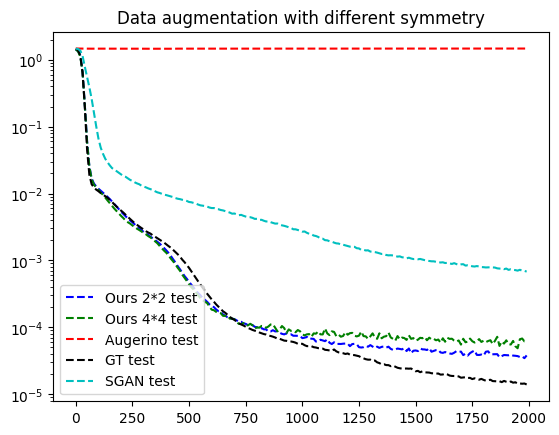

In [26]:
# plt.plot(np.arange(NUM_EPOCHS),train_losses[0],'-b',label='Ours 2*2 train')
plt.plot(np.arange(0,NUM_EPOCHS,TEST_PERIOD),test_losses[0],'--b',label='Ours 2*2 test')
# plt.plot(np.arange(NUM_EPOCHS),train_losses[1],'-g',label='Ours 4*4 train')
plt.plot(np.arange(0,NUM_EPOCHS,TEST_PERIOD),test_losses[1],'--g',label='Ours 4*4 test')
# plt.plot(np.arange(NUM_EPOCHS),train_losses[2],'-r',label='Augerino train')
plt.plot(np.arange(0,NUM_EPOCHS,TEST_PERIOD),test_losses[2],'--r',label='Augerino test')
# plt.plot(np.arange(NUM_EPOCHS),train_losses[3],'-k',label='GT train')
plt.plot(np.arange(0,NUM_EPOCHS,TEST_PERIOD),test_losses[3],'--k',label='GT test')
# plt.plot(np.arange(NUM_EPOCHS),train_losses[4],'-c',label='SGAN train')
plt.plot(np.arange(0,NUM_EPOCHS,TEST_PERIOD),test_losses[4],'--c',label='SGAN test')
plt.legend()
plt.title('Data augmentation with different symmetry')
plt.yscale('log')

In [27]:
[l[-1] for l in test_losses]

[3.78621589334216e-05,
 6.17414953012485e-05,
 1.4735084295272827,
 1.3921437039243756e-05,
 0.000679166876943782]